<a href="https://colab.research.google.com/github/siruku6/MathematicsTrial/blob/master/easily_understandable_pattern_recognition/chapter9_EM_for_1dim_normal_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1次元正規分布の混合正規分布に対する、EMアルゴリズムの適用

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 正規分布に従うデータの生成

$$
f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \\
\\
f(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{\frac{-(x - \mu)^2}{2 \sigma^2}} \\
$$

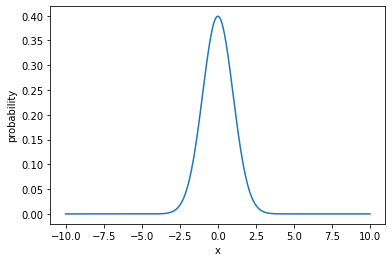

In [ ]:
# 標準正規分布
x = np.linspace(-10, 10, 1001)
y = np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

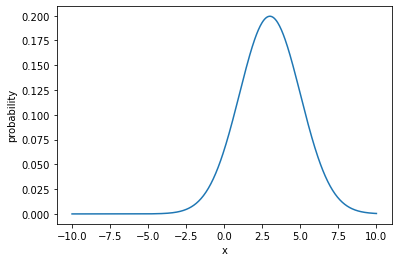

In [ ]:
def normal_dist(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    """
    xから、正規分布に従うyを出力する
    """
    exponent_portion = -(x - mu) ** 2 / (2 * sigma ** 2)
    denominator = (np.sqrt(2 * np.pi) * sigma) + 1e-8  # NOTE: to avoid division by zero
    f_x: np.ndarray = 1 / denominator * np.exp(exponent_portion)
    return f_x


mu = 3.0
sigma = 2.0
norm_pdf = normal_dist(x, mu, sigma)
plt.plot(x, norm_pdf)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

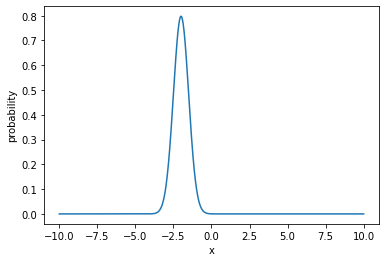

In [ ]:
mu = -2.0
sigma = 0.5

norm_pdf = normal_dist(x, mu, sigma)
plt.plot(x, norm_pdf)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

## 2. 混合正規分布の生成

$$
p(x) = \sum^K_{k=1} \pi_k N(x | \mu_k, 	\sigma_k)
$$


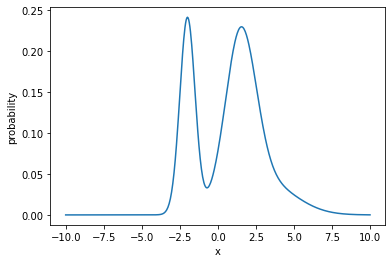

In [ ]:
# 前提条件
x = np.linspace(-10, 10, 501)
mu = [3.0, -2.0, 1.5]
sigma = [2.0, 0.5, 1.0]
pi = [0.2, 0.3, 0.5]

# 混合正規分布のデータを生成
norms = [
    normal_dist(x, _mu, _sigma) for _mu, _sigma in zip(mu, sigma)
]
mixed_norm = norms[0] * pi[0] + norms[1] * pi[1] + norms[2] * pi[2]

plt.plot(x, mixed_norm)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

## 3. 対数尤度関数の計算

In [ ]:
def calc_likelihood(
    x: np.ndarray, pi_hat: np.ndarray, mu_hat: np.ndarray, sigma_hat: np.ndarray
) -> np.ndarray:
    """
    Parameters
    ------
    x: observed values
        Type: np.ndarray
        Shape: 1-dimension (Number of observed values)
    mu_hat: Expectations
        Type: np.ndarray
        Shape: 1-dimension (Number of kinds of Norm dist)
    sigma_hat: 
        Type: Variances
        Shape: 1-dimension (Number of kinds of Norm dist)
    
    Return
    ------
    Shape: 2-dimension (Number of observed values, Number of kinds of Norm dist)
    """
    num_categories = len(mu_hat)
    tmp_dists = normal_dist(np.tile(x, (num_categories, 1)).T, mu_hat, sigma_hat)
    likelihood = pi_hat * np.log(tmp_dists)
    return likelihood


# 各パラメータの推定値の初期値（仮）
mu_hat = np.array([1.0, 2.0, 3.0])
sigma_hat = np.array([0.25, 0.75, 1.5])
pi_hat = np.array([0.4, 0.5, 0.1])

# 対数尤度の計算
log_likelihood: np.ndarray = calc_likelihood(mixed_norm, pi_hat, mu_hat, sigma_hat)
sum_log_likelihood = np.sum(log_likelihood, axis=1)
sum_sum_log_likelihood = np.sum(sum_log_likelihood)
sum_sum_log_likelihood


-2531.556204481004